In [118]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from datetime import datetime, timedelta
import joblib

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [3]:
df_ano = pd.read_csv('./annonimized.csv')
rename_map={
    "concat('it001',`assignment_id`)": 'assignment_id',
    "concat('it001',`problem_id`)": 'problem_id',
    "concat('it001', username)": 'username',
    "concat('it001',`language_id`)": "language_id"
}
df_ano.rename(columns=rename_map, inplace=True)
df_ano_original = pd.read_csv("./annonimized.csv")
df_ano_original.rename(columns=rename_map, inplace=True)

In [11]:
df_ano_original.head()

,assignment_id,problem_id,username,is_final,status,pre_score,coefficient,language_id,created_at,updated_at,judgement
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."


In [4]:
df_tbtl = pd.read_excel('./tbtl-public.ods',engine='odf')

In [5]:
df_ano = df_ano[df_ano['username'].isin(df_tbtl['username'].values)]
print(*df_ano["status"].unique())
class_id_map = {}
for idx, class_id in enumerate(df_ano["language_id"].unique()):
    class_id_map[class_id] = class_id_map[class_id] = idx
print(class_id_map)

Compilation Error SCORE Syntax Error pending
{'it0012': 0, 'it0014': 1, 'it0013': 2, 'it0011': 3, 'it0015': 4}


In [53]:
temp_stu_id = df_ano["username"].unique()[0]
df_temp_view = df_ano[df_ano["username"] == temp_stu_id]
df_child = df_temp_view[df_temp_view["is_final"] == 1]
print(len(df_child))
print(len(df_temp_view))

54
220


In [106]:
def extract_student_infos(df_ano, df_scores, scores_col_name="TBTL"):
    stu_ids = df_ano['username'].unique()
    time_gaps = []
    max_scores = []
    mean_scores = []
    score_statuses = []
    final_statuses = []
    assignment_counts = []
    submissions_counts = []
    assign_vs_sub = []

    for stu_id in stu_ids:
        df_stu_view = df_ano[df_ano["username"] == stu_id]
        assignment_counts.append(len(df_stu_view["assignment_id"].unique()))
        df_is_final = df_stu_view[df_stu_view["is_final"] == 1]
        # print(f"{len(df_is_final)}/{len(df_stu_view)}")
        stu_final_status = len(df_is_final) / len(df_stu_view)
        final_statuses.append(stu_final_status)
        submissions_counts.append(len(df_stu_view))
        assign_vs_sub.append(len(df_stu_view["assignment_id"].unique()) / len(df_stu_view))
        # Attempt to parse dates, handle errors
        # try:
        #     df_stu_view["created_at_parsed"] = pd.to_datetime(
        #         df_stu_view["created_at"], format="%m-%d %H:%M:%S", errors="coerce"
        #     )
        # except ValueError as e:
        #     print(f"Error parsing dates for student {stu_id}: {e}")
        #     continue

        # # Calculate the maximum and minimum times
        # max_time = df_stu_view["created_at_parsed"].max()
        # min_time = df_stu_view["created_at_parsed"].min()
        # # Calculate the difference
        # time_gap = max_time - min_time
        # total_seconds = time_gap.total_seconds()
        # if(time_gap>timedelta(days=180)):
        #     time_gap = timedelta(days=365) - time_gap
        #     total_seconds = time_gap.total_seconds()

        # grouped_max = df_stu_view.groupby("assignment_id")["pre_score"].max().reset_index()

        # grouped_mean = df_stu_view['pre_score'].mean()
        # # print(f"grouped_mean: {grouped_mean} \n grouped_count: {pre_score_count} \n grouped_sum: {pre_score_sum}")
        # # print(grouped_mean)

        # total_score_status = len(df_stu_view[df_stu_view["status"] == "SCORE"])
        # total_status = len(df_stu_view)
        # # print(f"score_statuses: {score_statuses} / total_status: {total_status}")
        # time_gaps.append(total_seconds)
        # max_scores.append(grouped_max["pre_score"].mean())
        # mean_scores.append(grouped_mean)
        # score_statuses.append(total_score_status / total_status)

    if scores_col_name == None:
        return pd.DataFrame(
            {
                "username": stu_ids,
                "final_statuses": final_statuses,
                "assignment_counts": assignment_counts,
                "submissions_counts": submissions_counts,
                "assign_vs_sub": assign_vs_sub,
                # "time_gaps": time_gaps,
                # "max_scores": max_scores,
                # "mean_scores": mean_scores,
                # "score_statuses": score_statuses,
            }
        )
    else:
        scores = df_scores[scores_col_name]
        return pd.DataFrame(
            {
                "username": stu_ids,
                "final_statuses": final_statuses,
                "assignment_counts": assignment_counts,
                "submissions_counts": submissions_counts,
                "assign_vs_sub": assign_vs_sub,
                # "time_gaps": time_gaps,
                # "max_scores": max_scores,
                # "mean_scores": mean_scores,
                # "score_statuses": score_statuses,
                scores_col_name: scores,
            }
        )

In [107]:
df_stu_clean = extract_student_infos(df_ano, df_tbtl, scores_col_name="TBTL")

In [108]:
df_stu_clean

,username,final_statuses,assignment_counts,submissions_counts,assign_vs_sub,TBTL
0,0bd2037bf68a97753e5e67ab55dac026a649f279,0.245455,5,220,0.022727,7.24
1,83e4ca230ab9b35d221d09d335850af44966b772,0.333333,1,3,0.333333,8.11
2,0dfa65b4dafad47b15abbfd6c6ce1aeb213901cf,0.196581,5,117,0.042735,7.30
3,67d64015616b9e7f49e213890b7b93a2f8796f07,0.259341,21,455,0.046154,8.63
4,18fc5492e3a88861f35c23bbb2805f724c1a135a,0.328571,7,140,0.050000,8.20
...,...,...,...,...,...,...
794,01ad03ec301749c033155fc17e657cc767d447c8,0.273063,12,271,0.044280,7.67
795,4932174dcf0408a7eb862930c9c6be33d30825a6,1.000000,1,1,1.000000,7.54
796,508e0627871ed482bd8ab34544e43e5d856a889c,0.351064,4,94,0.042553,7.49
797,02c88d535d7393d30ce3338174d0a17ee7e8b8cc,0.401130,5,177,0.028249,8.94


## PREPARING FOR VISUALIZATION

### CORRELATION VISUALIZING

In [109]:
def plot_correlation(df):
    corr_matrix = (df.drop(["username"], axis=1)).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        vmin=-1,
        vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.7},
    )
    plt.title("Correlation Matrix Heatmap")
    plt.show()

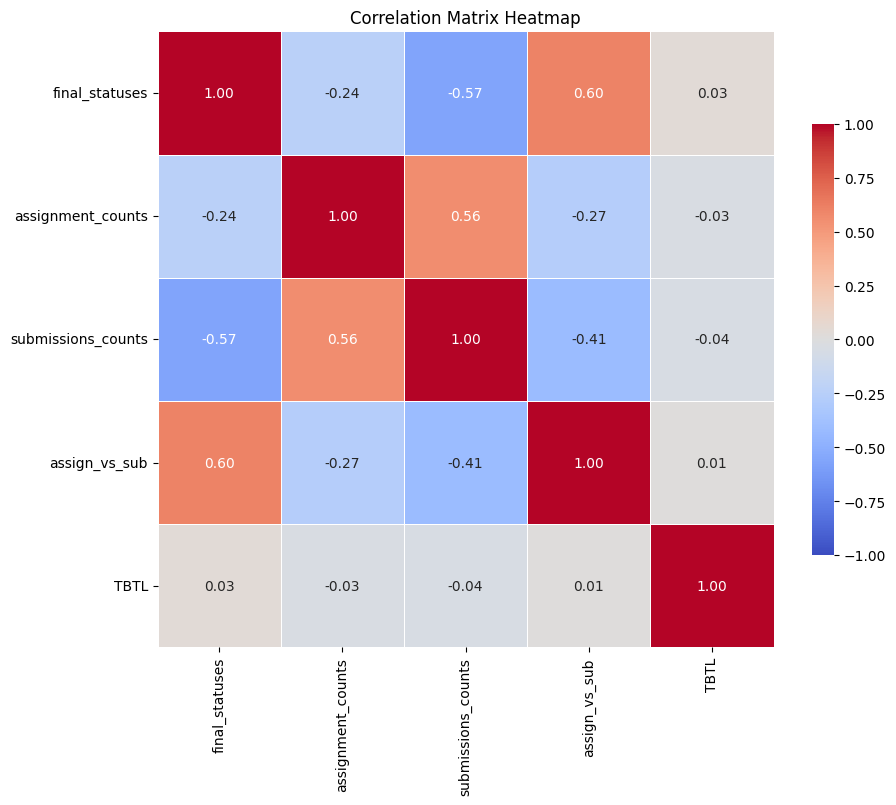

In [110]:
plot_correlation(df_stu_clean)

In [ ]:
df_stu_clean

,username,class_idx,time_gaps,max_scores,mean_scores,score_statuses,TBTL
0,0bd2037bf68a97753e5e67ab55dac026a649f279,0,3947718.0,8000.000000,4550.186364,0.740909,7.24
1,83e4ca230ab9b35d221d09d335850af44966b772,0,1604.0,3461.000000,1153.666667,0.666667,8.11
2,0dfa65b4dafad47b15abbfd6c6ce1aeb213901cf,0,4935874.0,6000.000000,1771.316239,0.478632,7.30
3,67d64015616b9e7f49e213890b7b93a2f8796f07,0,667796.0,9190.476190,5525.178022,0.865934,8.63
4,18fc5492e3a88861f35c23bbb2805f724c1a135a,0,3848928.0,8081.571429,5629.900000,0.878571,8.20
...,...,...,...,...,...,...,...
794,01ad03ec301749c033155fc17e657cc767d447c8,0,1341363.0,9166.666667,5182.265683,0.804428,7.67
795,4932174dcf0408a7eb862930c9c6be33d30825a6,0,0.0,10000.000000,10000.000000,1.000000,7.54
796,508e0627871ed482bd8ab34544e43e5d856a889c,0,3305859.0,10000.000000,5483.404255,0.797872,7.49
797,02c88d535d7393d30ce3338174d0a17ee7e8b8cc,0,3058711.0,10000.000000,6998.463277,0.932203,8.94


### Plotting features vs target

In [120]:
def plot_interactive_3d_features_vs_target(dataframe, feature_1, feature_2, target_col_name):
    # Check if the columns exist in the dataframe
    for col in [feature_1, feature_2, target_col_name]:
        if col not in dataframe.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame.")
    
    # Create a 3D scatter plot
    fig = px.scatter_3d(
        dataframe, 
        x=feature_1, 
        y=feature_2, 
        z=target_col_name,
        title=f"Interactive 3D Plot of {feature_1} and {feature_2} vs {target_col_name}",
        labels={feature_1: feature_1, feature_2: feature_2, target_col_name: target_col_name}
    )

    # Show plot
    fig.show()

In [121]:
["username", "TBTL"]
for i in range(len(df_stu_clean.columns)):
		for j in range(i + 1, len(df_stu_clean.columns)):
				if df_stu_clean.columns[i] not in ["username", "TBTL"] and df_stu_clean.columns[j] not in ["username", "TBTL"]:
						plot_interactive_3d_features_vs_target(df_stu_clean, df_stu_clean.columns[i], df_stu_clean.columns[j], "TBTL")


# for col_name in df_stu_clean.columns:
#     if col_name not in ["username", "TBTL"]:
#         plot_3d_features_vs_target(df_stu_clean, col_name, "TBTL")

In [113]:
def plot_feature_vs_target(dataframe, feature_col_name, target_col_name):
    if feature_col_name not in dataframe.columns:
        raise ValueError(
            f"Feature column '{feature_col_name}' does not exist in the DataFrame."
        )

    if target_col_name not in dataframe.columns:
        raise ValueError(
            f"Target column '{target_col_name}' does not exist in the DataFrame."
        )

    plt.figure(figsize=(10, 6))
    plt.scatter(dataframe[feature_col_name], dataframe[target_col_name], marker="o")
    plt.title(f"Plot of {feature_col_name} vs {target_col_name}")
    plt.xlabel(feature_col_name)
    plt.ylabel(target_col_name)
    plt.grid(True)
    plt.show()

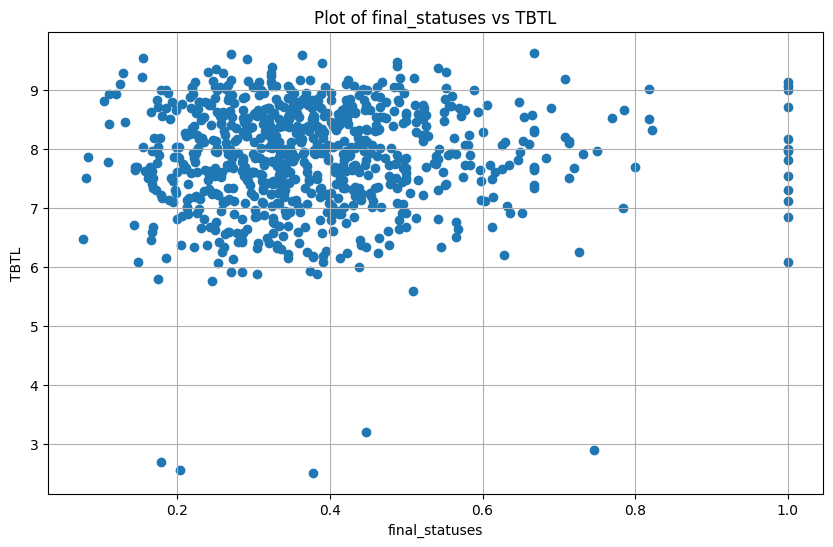

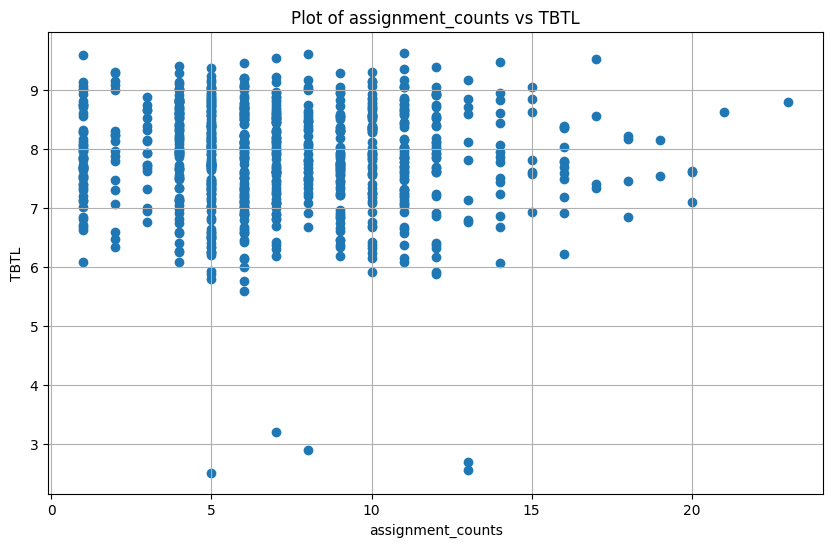

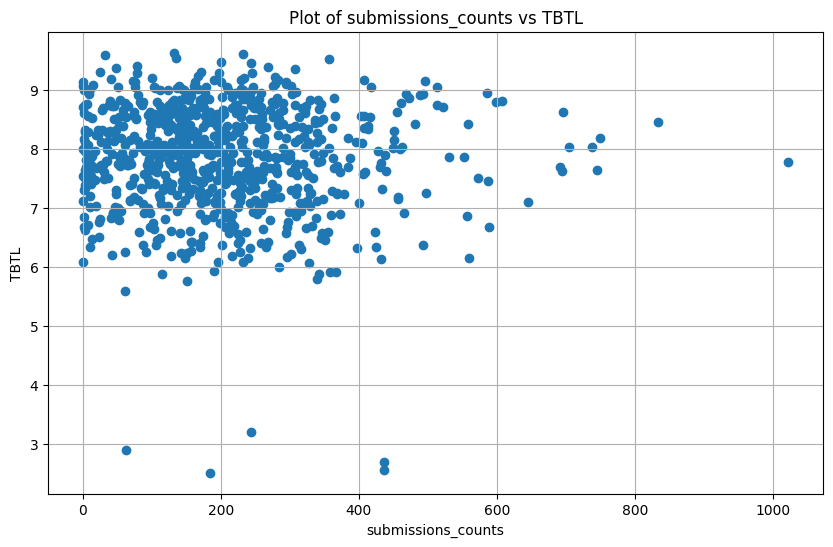

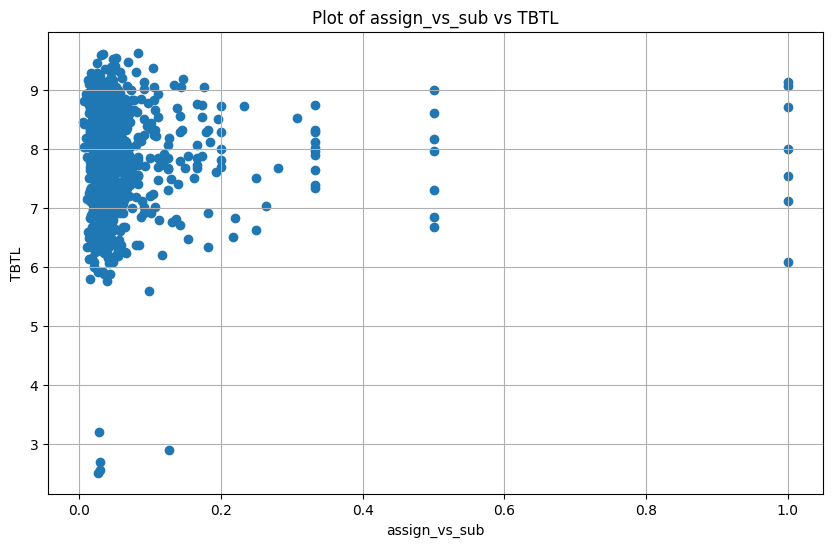

In [114]:
# for col_name in df_ano.columns:
# (df_ano.columns).remove('assignment_id','problem_id')
['username',"TBTL"]
for col_name in df_stu_clean.columns:
    if col_name not in ['username',"TBTL"]:
        plot_feature_vs_target(df_stu_clean, col_name, "TBTL")

from this dataframe, use svm from scikit learn to predict the value of the final column for me , have a test split of 10%

### TRAINING FOR TBTL-score (accumulated mean scores)

In [254]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Assuming df_stu_clean is already defined

# Split the data into features and target
X = df_stu_clean.drop(columns=["username", "TBTL", "class_idx"])
y = df_stu_clean["TBTL"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Scale the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Create and train the SVR model
svr = SVR()
svr.fit(X_train_scaled, y_train_scaled)

# Predict the target values for the test set
y_pred_scaled = svr.predict(X_test_scaled)

# Inverse transform the scaled predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)

print("R^2 score:", r2)
joblib.dump(svr, "svr_model.pkl")
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# Print out the predictions compared to the ground truth
print("\nPredictions compared to ground truth:")
for true_value, predicted_value in zip(y_test, y_pred):
    print(f"True: {true_value:.2f}, Predicted: {predicted_value:.2f}")

R^2 score: -0.09573105104149704

Predictions compared to ground truth:
True: 8.35, Predicted: 7.53
True: 6.95, Predicted: 7.96
True: 6.17, Predicted: 8.05
True: 6.84, Predicted: 7.89
True: 7.31, Predicted: 8.05
True: 7.65, Predicted: 7.89
True: 8.53, Predicted: 7.88
True: 8.94, Predicted: 7.96
True: 8.84, Predicted: 8.24
True: 7.56, Predicted: 8.17
True: 7.61, Predicted: 8.03
True: 7.42, Predicted: 8.18
True: 7.86, Predicted: 7.77
True: 8.63, Predicted: 8.39
True: 8.51, Predicted: 8.14
True: 8.58, Predicted: 8.11
True: 8.32, Predicted: 8.60
True: 7.21, Predicted: 7.72
True: 8.99, Predicted: 8.43
True: 7.26, Predicted: 7.62
True: 9.15, Predicted: 7.59
True: 8.70, Predicted: 7.77
True: 7.93, Predicted: 7.59
True: 8.81, Predicted: 8.22
True: 7.08, Predicted: 7.96
True: 8.51, Predicted: 7.45
True: 6.82, Predicted: 7.90
True: 8.37, Predicted: 8.14
True: 7.12, Predicted: 8.11
True: 9.28, Predicted: 8.26
True: 8.23, Predicted: 8.00
True: 7.81, Predicted: 8.31
True: 7.49, Predicted: 7.98
True:

### Preparing for predictions

### FILTER TO HOLD NON-LABELED students into a dataframe

In [25]:
df_ano_not_tbtl = df_ano_original[
    ~df_ano_original["username"].isin(df_tbtl["username"].values)
]

In [26]:
df_ano_not_tbtl = extract_student_infos(df_ano_not_tbtl, None,None)
df_ano_not_tbtl

C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

,username,time_gaps,max_scores,mean_scores,score_statuses
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,5062661.0,10000.0,5305.553957,0.755396
1,ba12c0a2cb367af0467e479c03507c71a805d291,168839.0,10000.0,5228.576803,0.768025
2,b7298b0fe50443a623af9b56792b330c2d052845,214985.0,10000.0,5998.854251,0.854251
3,c60be70309789b39355dc612f36e37090ccad5dc,138553.0,9500.0,6237.773256,0.848837
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,3343121.0,10000.0,5547.465278,0.868056
...,...,...,...,...,...
685,f0d74f349e6479eaecf425634f8b0dd51e60d60c,3850131.0,10000.0,5362.000000,0.829694
686,d525d6edf4b0c6362ddaa4814c3930a6a62bdc99,398989.0,10000.0,6124.041475,0.820276
687,b722e6209f2858faf0bf80947cadcbde586bb666,3957666.0,10000.0,4178.058824,0.830882
688,b45e8d507778dab56f381a681c453cbf4d3b4050,773078.0,8000.0,4841.418440,0.666667


### DEFINE FUNCTION FOR PREDICTIONS

In [260]:
# Assuming df_stu_clean is already defined

# Split the data into features and target
def pred_non_labeled(df_stu_clean,y_pred=[]):
    usernames = df_stu_clean["username"]

    X = df_stu_clean.drop(columns=["username" ])

    scaler_X = joblib.load("./scaler_X.pkl")
    X_test = df_stu_clean.drop(columns=["username"])
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = joblib.load("./scaler_y.pkl")
    # y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

    svr_loaded = joblib.load("./svr_model.pkl")

    y_pred_scaled = svr_loaded.predict(X_test_scaled)

    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    y_pred = [round(pred, 2) for pred in y_pred]

    # print("\nPredictions compared to ground truth:")
    # for username_id, predicted_value in zip(usernames, y_pred):
    #     print(f"Username: {username_id}, Predicted: {predicted_value:.2f}")
    return pd.DataFrame({"username": usernames, "predictions": y_pred})

### Start predicting

In [261]:
df_predictions = pred_non_labeled(df_ano_not_tbtl)

#### View some of the predicted

In [262]:
df_predictions

,username,predictions
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,8.10
1,ba12c0a2cb367af0467e479c03507c71a805d291,7.80
2,b7298b0fe50443a623af9b56792b330c2d052845,7.99
3,c60be70309789b39355dc612f36e37090ccad5dc,8.04
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,7.94
...,...,...
685,f0d74f349e6479eaecf425634f8b0dd51e60d60c,7.91
686,d525d6edf4b0c6362ddaa4814c3930a6a62bdc99,7.93
687,b722e6209f2858faf0bf80947cadcbde586bb666,7.67
688,b45e8d507778dab56f381a681c453cbf4d3b4050,8.08


#### SAVING THE PREDICTIONS FOR SUBMISSIONS

In [263]:
df_predictions.to_csv("predictions_tbtl_2.csv", index=False,header=None)

### PREPARING TRAINING FOR Student's final score prediction

In [27]:
df_final_score = pd.read_csv('./ck-public.csv')
df_ano_final_score = df_ano_original

In [29]:
df_final_score

,hash,CK
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,6.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,4.5
3,013de369c439ab0ead8aa7da64423aa395a8be39,5.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,4.0
...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,5.5
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,6.0
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,6.0
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,7.0


In [31]:
df_ano_final_score = df_ano_final_score[
    df_ano_final_score["username"].isin(df_final_score["hash"].values)
]
df_ano_final_score.head(4)

,assignment_id,problem_id,username,is_final,status,pre_score,coefficient,language_id,created_at,updated_at,judgement
458,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,0bd2037bf68a97753e5e67ab55dac026a649f279,0,Compilation Error,0,100,it0012,10-11 16:15:32,10-11 16:16:36,"{""times"":[],""mems"":[],""verdicts"":{""\n\nforbidd..."
459,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,0bd2037bf68a97753e5e67ab55dac026a649f279,0,Compilation Error,0,100,it0012,10-11 16:16:30,10-11 16:16:31,"{""times"":[],""mems"":[],""verdicts"":{""\n\nforbidd..."
460,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,0bd2037bf68a97753e5e67ab55dac026a649f279,0,Compilation Error,0,100,it0012,10-11 16:23:46,10-11 16:43:17,"{""times"":[],""mems"":[],""verdicts"":{""\n\nforbidd..."
461,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,0bd2037bf68a97753e5e67ab55dac026a649f279,0,Compilation Error,0,100,it0012,10-11 16:25:55,10-11 16:25:56,"{""times"":[],""mems"":[],""verdicts"":{""\n\nforbidd..."


In [32]:
df_stu_final_clean = extract_student_infos(
    df_ano_final_score, df_final_score, scores_col_name="CK"
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [33]:
df_stu_final_clean

,username,time_gaps,max_scores,mean_scores,score_statuses,CK
0,0bd2037bf68a97753e5e67ab55dac026a649f279,3947718.0,8000.000000,4550.186364,0.740909,5.5
1,83e4ca230ab9b35d221d09d335850af44966b772,1604.0,3461.000000,1153.666667,0.666667,6.5
2,0dfa65b4dafad47b15abbfd6c6ce1aeb213901cf,4935874.0,6000.000000,1771.316239,0.478632,4.5
3,67d64015616b9e7f49e213890b7b93a2f8796f07,667796.0,9190.476190,5525.178022,0.865934,5.0
4,18fc5492e3a88861f35c23bbb2805f724c1a135a,3848928.0,8081.571429,5629.900000,0.878571,4.0
...,...,...,...,...,...,...
756,6405b9839b0179e5307afdb5117992033c2a9cbd,250451.0,10000.000000,4423.969365,0.814004,5.5
757,01ad03ec301749c033155fc17e657cc767d447c8,1341363.0,9166.666667,5182.265683,0.804428,6.0
758,4932174dcf0408a7eb862930c9c6be33d30825a6,0.0,10000.000000,10000.000000,1.000000,6.0
759,02c88d535d7393d30ce3338174d0a17ee7e8b8cc,3058711.0,10000.000000,6998.463277,0.932203,7.0


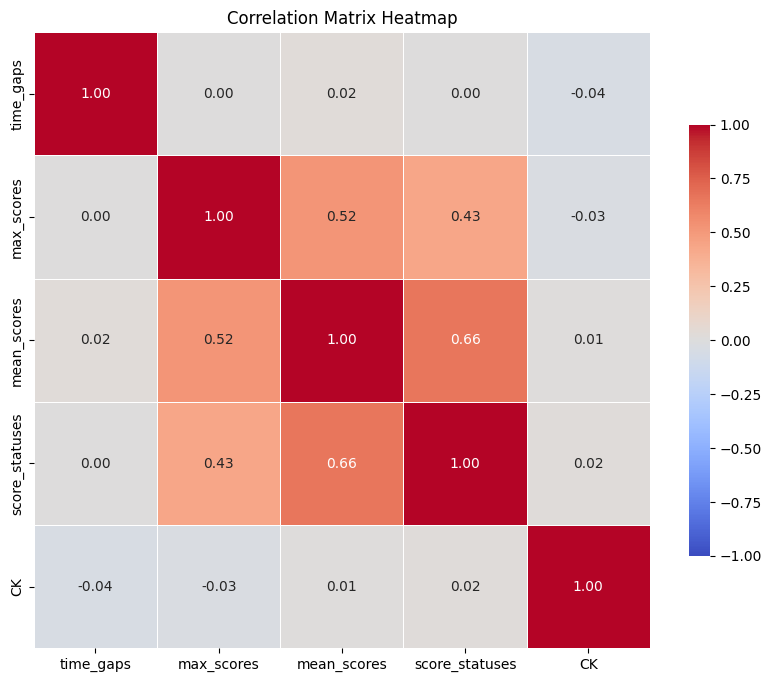

In [34]:
plot_correlation(df_stu_final_clean)

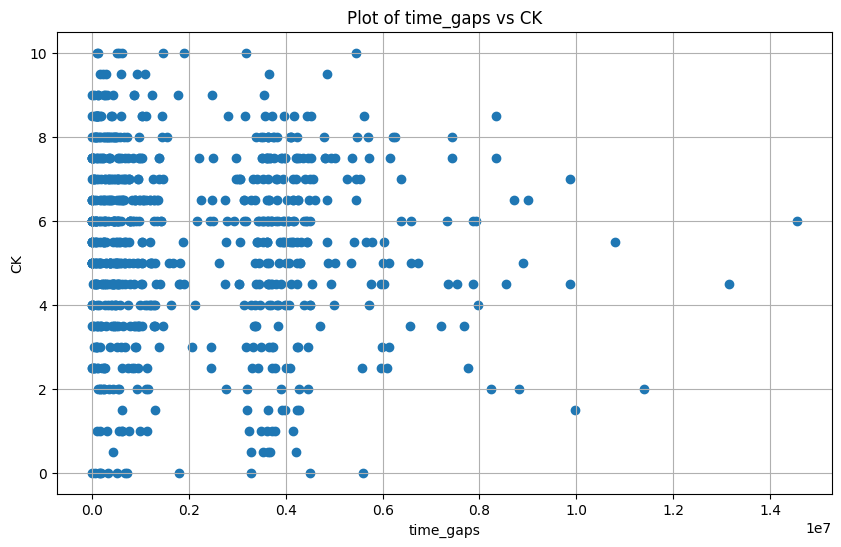

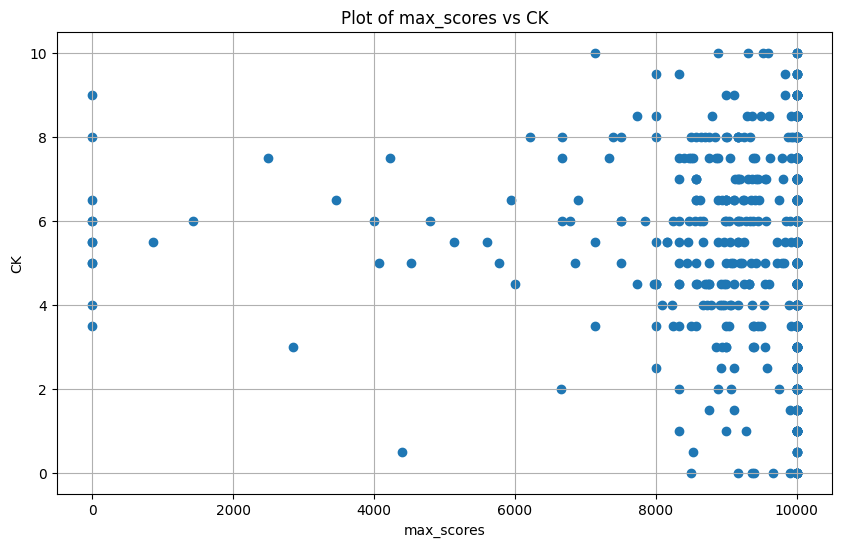

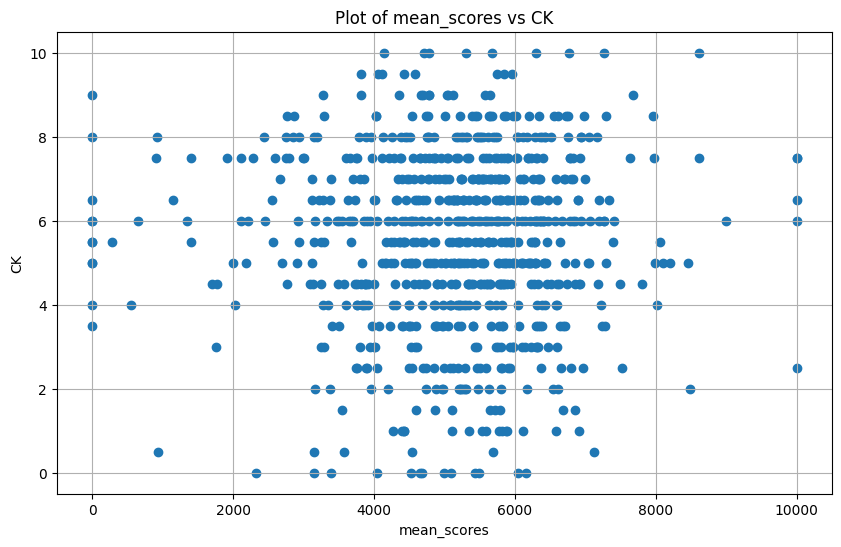

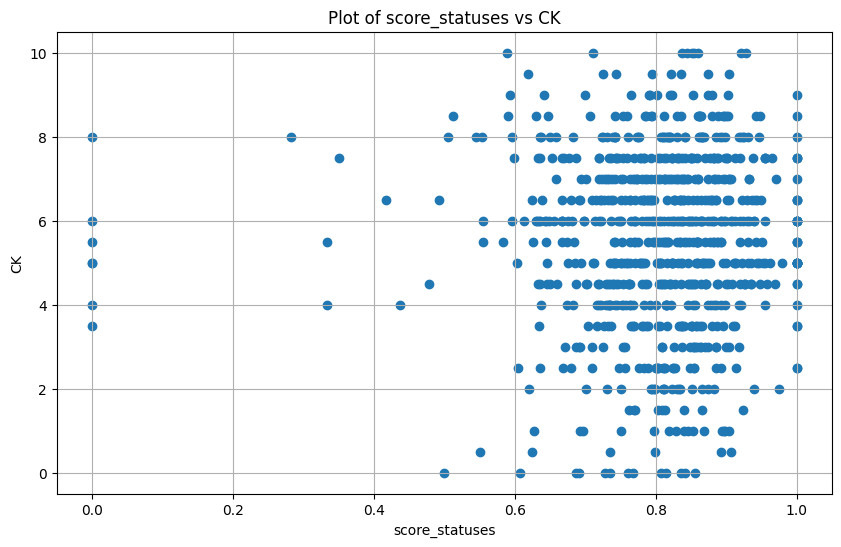

In [35]:
except_cols = ["username", "CK"]
for col_name in df_stu_final_clean.columns:
    if col_name not in except_cols:
        plot_feature_vs_target(df_stu_final_clean, col_name, "CK")

In [70]:
# Assuming df_stu_clean is already defined

def train_data_svr(df,target_colname="CK", 
                     scaler_X_filename="scaler_X_final.pkl", 
                     scaler_y_filename="scaler_y_final.pkl", 
                     model_filename="svr_model_final.pkl"):
    # Split the data into features and target
    df = df.dropna()
    X = df.drop(columns=["username", target_colname])
    y = df[target_colname]
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # Scale the features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale the target
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    # y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

    # Create and train the SVR model
    svr = SVR()
    svr.fit(X_train_scaled, y_train_scaled)

    # Predict the target values for the test set
    y_pred_scaled = svr.predict(X_test_scaled)

    # Inverse transform the scaled predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    joblib.dump( scaler_X,scaler_X_filename,)
    joblib.dump(scaler_y,scaler_y_filename )
    joblib.dump(svr, model_filename)

    # Calculate the R^2 score
    r2 = r2_score(y_test, y_pred)

    print("R^2 score:", r2)

    # Print out the predictions compared to the ground truth
    print("\nPredictions compared to ground truth:")
    for true_value, predicted_value in zip(y_test, y_pred):
        print(f"True: {true_value:.2f}, Predicted: {predicted_value:.2f}")

In [54]:
train_data_svr(df_stu_final_clean, target_colname="CK",
               scaler_X_filename="scaler_X_final.pkl",scaler_y_filename="scaler_y_final.pkl",
               model_filename="svr_model_final.pkl")

R^2 score: 0.04513505810303875

Predictions compared to ground truth:
True: 5.50, Predicted: 6.31
True: 3.00, Predicted: 5.56
True: 7.00, Predicted: 5.66
True: 4.00, Predicted: 5.90
True: 3.00, Predicted: 5.46
True: 5.50, Predicted: 5.19
True: 4.50, Predicted: 4.94
True: 4.00, Predicted: 5.05
True: 2.00, Predicted: 5.74
True: 5.00, Predicted: 6.07
True: 7.50, Predicted: 5.84
True: 0.00, Predicted: 5.76
True: 4.00, Predicted: 5.61
True: 5.50, Predicted: 6.84
True: 7.50, Predicted: 6.21
True: 4.50, Predicted: 5.62
True: 2.50, Predicted: 5.59
True: 7.50, Predicted: 5.75
True: 6.00, Predicted: 5.62
True: 7.00, Predicted: 5.62
True: 6.50, Predicted: 5.83
True: 8.00, Predicted: 5.48
True: 4.50, Predicted: 5.81
True: 10.00, Predicted: 5.43
True: 2.00, Predicted: 5.86
True: 8.00, Predicted: 6.22
True: 9.00, Predicted: 5.82
True: 3.00, Predicted: 5.40
True: 6.50, Predicted: 5.80
True: 8.00, Predicted: 6.83
True: 4.50, Predicted: 5.82
True: 8.00, Predicted: 5.97
True: 5.00, Predicted: 5.58
True:

In [61]:
# Assuming df_stu_clean is already defined
# Split the data into features and target
def pred_non_labeled_clean(df, y_pred=[], drop_col="username",
                           scaler_X_filename="scaler_X_final.pkl",
                           scaler_y_filename="scaler_y_final.pkl",
                           model_filename="svr_model_final.pkl"):
    usernames = df["username"]

    X = df.drop(columns=["username"])

    scaler_X = joblib.load(scaler_X_filename)
    X_test = df.drop(columns=["username"])
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = joblib.load(scaler_y_filename)
    # y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    svr_loaded = joblib.load(model_filename)

    y_pred_scaled = svr_loaded.predict(X_test_scaled)

    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    y_pred = [round(pred, 2) for pred in y_pred]
    return pd.DataFrame({"username": usernames, "predictions": y_pred})

In [57]:
df_final_score_non_labled = df_ano_original[~df_ano_original["username"].isin(df_final_score["hash"].values)]
df_final_score_non_labled = extract_student_infos(df_final_score_non_labled, None, None)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [63]:
df_final_predictions = pred_non_labeled_clean(
    df_final_score_non_labled,
    y_pred=[],
    drop_col="username",
    scaler_X_filename="scaler_X_final.pkl",
    scaler_y_filename="scaler_y_final.pkl",
    model_filename="svr_model_final.pkl",
)
df_final_predictions.head(10)

,username,predictions
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,5.54
1,ba12c0a2cb367af0467e479c03507c71a805d291,5.51
2,b7298b0fe50443a623af9b56792b330c2d052845,5.80
3,c60be70309789b39355dc612f36e37090ccad5dc,6.00
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,5.76
5,d5841f944022e9ef49bf6ac9b5546dd82ab2784f,5.72
6,eb451c65ea210bed6af798282c2c6205c79f71fd,5.83
7,c3e73d0362e2b21fae6edfcf518063e8a28b7b63,5.61
8,df9e2c6cfb6035fa5b26af3b101bacf64e95e913,5.66
9,99103791231143dd15aa77f2aeb87b2cd4a1c22e,5.75


In [64]:
df_final_predictions.to_csv('predictions_final.csv',index=False,header=None)

### PREPARING FOR TH-SCORES (practice scores)

In [124]:
df_th_score = pd.read_csv('./th-public.csv')
df_th_score

,hash,TH
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7
3,013de369c439ab0ead8aa7da64423aa395a8be39,10
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,6
...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,6
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,8.5
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,5.5
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,10


In [125]:
df_ano_th_score = df_ano_original[
    df_ano_original["username"].isin(df_th_score["hash"].values)
]
df_ano_th_score_clean = extract_student_infos(
    df_ano_th_score, df_th_score, scores_col_name="TH"
)
df_ano_th_score_clean["TH"] = pd.to_numeric(
    df_ano_th_score_clean["TH"].astype(str).str.replace("\xa0", "").str.strip(),
    errors="coerce",
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

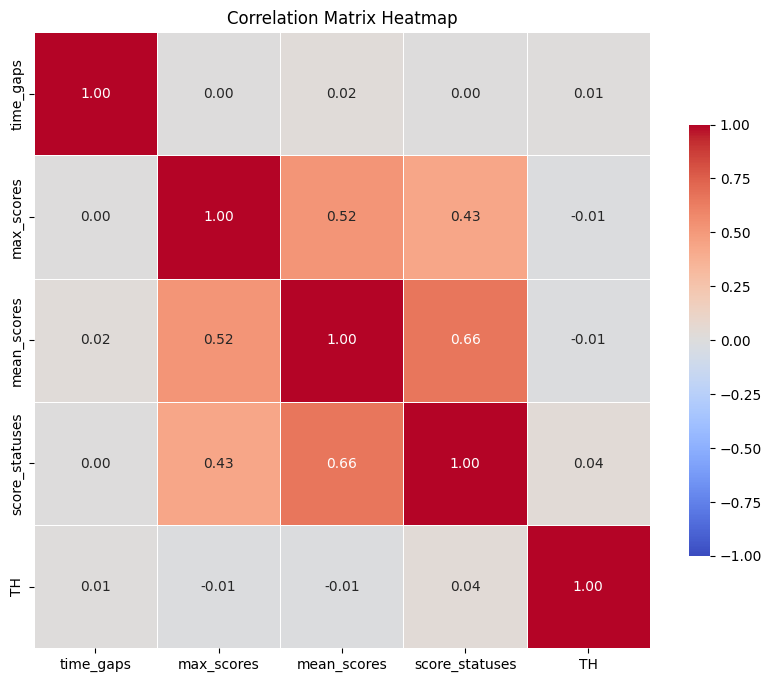

In [126]:
plot_correlation(df_ano_th_score_clean)

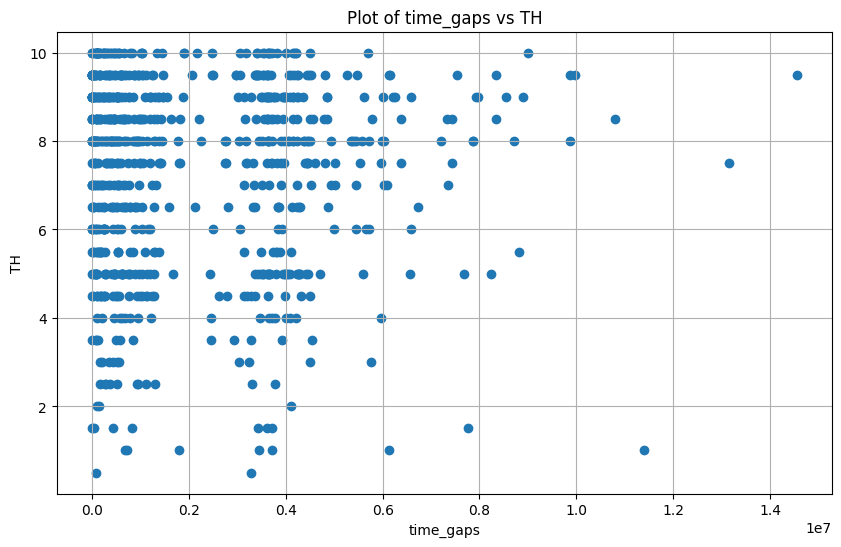

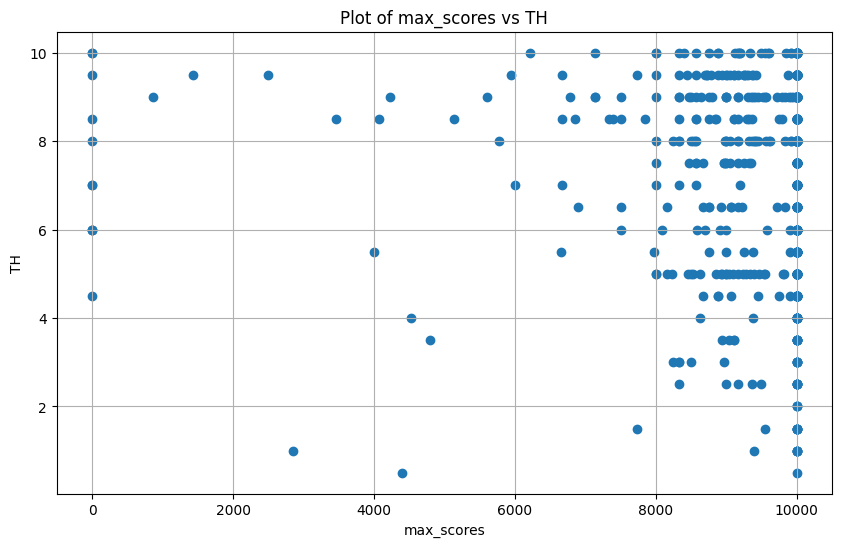

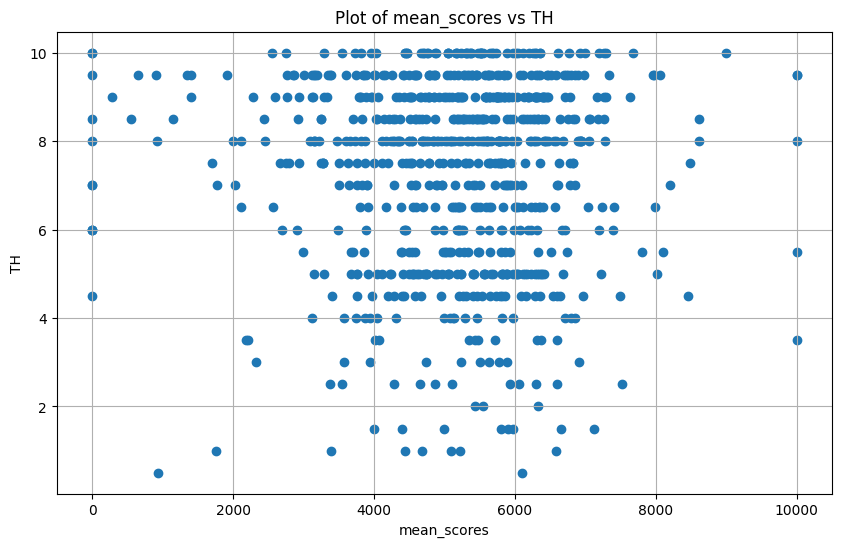

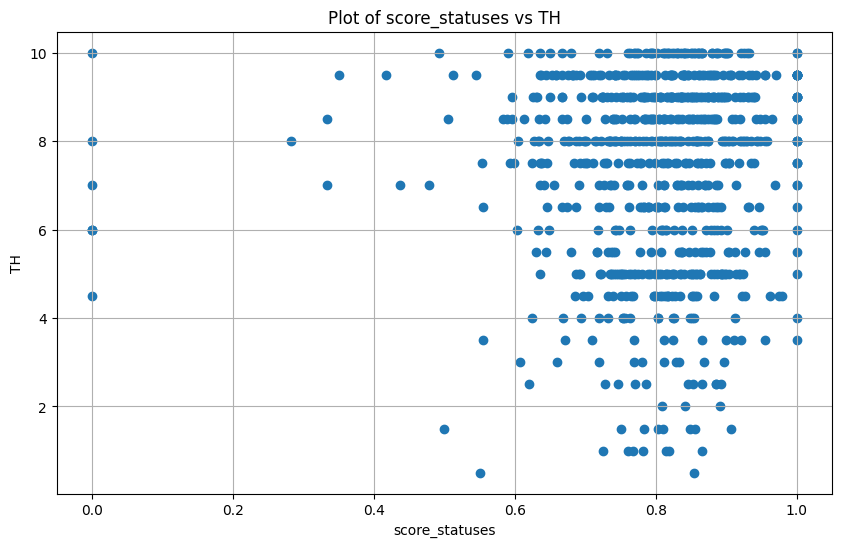

In [127]:
for col_name in df_ano_th_score_clean.columns:
    if col_name not in ["username", "TH"]:
        plot_feature_vs_target(df_ano_th_score_clean, col_name, "TH")

In [128]:
df_ano_th_score_clean

,username,time_gaps,max_scores,mean_scores,score_statuses,TH
0,0bd2037bf68a97753e5e67ab55dac026a649f279,3947718.0,8000.000000,4550.186364,0.740909,5.0
1,83e4ca230ab9b35d221d09d335850af44966b772,1604.0,3461.000000,1153.666667,0.666667,8.5
2,0dfa65b4dafad47b15abbfd6c6ce1aeb213901cf,4935874.0,6000.000000,1771.316239,0.478632,7.0
3,67d64015616b9e7f49e213890b7b93a2f8796f07,667796.0,9190.476190,5525.178022,0.865934,10.0
4,18fc5492e3a88861f35c23bbb2805f724c1a135a,3848928.0,8081.571429,5629.900000,0.878571,6.0
...,...,...,...,...,...,...
756,6405b9839b0179e5307afdb5117992033c2a9cbd,250451.0,10000.000000,4423.969365,0.814004,6.0
757,01ad03ec301749c033155fc17e657cc767d447c8,1341363.0,9166.666667,5182.265683,0.804428,8.5
758,4932174dcf0408a7eb862930c9c6be33d30825a6,0.0,10000.000000,10000.000000,1.000000,5.5
759,02c88d535d7393d30ce3338174d0a17ee7e8b8cc,3058711.0,10000.000000,6998.463277,0.932203,10.0


In [146]:
train_data_svr(df_ano_th_score_clean,
                target_colname="TH",
                model_filename="svr_model_th.pkl", scaler_X_filename="scaler_X_th.pkl",scaler_y_filename="scaler_y_th.pkl")

R^2 score: 0.0013861740001566147

Predictions compared to ground truth:
True: 6.00, Predicted: 8.20
True: 5.00, Predicted: 7.80
True: 10.00, Predicted: 7.47
True: 9.50, Predicted: 8.03
True: 5.50, Predicted: 8.31
True: 9.00, Predicted: 9.67
True: 6.00, Predicted: 7.96
True: 5.00, Predicted: 7.89
True: 8.00, Predicted: 7.53
True: 10.00, Predicted: 8.04
True: 9.00, Predicted: 7.76
True: 6.50, Predicted: 7.68
True: 9.50, Predicted: 7.37
True: 9.00, Predicted: 7.94
True: 5.00, Predicted: 7.64
True: 9.50, Predicted: 8.37
True: 6.00, Predicted: 7.83
True: 10.00, Predicted: 8.35
True: 6.50, Predicted: 7.56
True: 10.00, Predicted: 7.52
True: 9.00, Predicted: 7.59
True: 8.00, Predicted: 7.87
True: 6.00, Predicted: 7.79
True: 8.00, Predicted: 7.22
True: 9.00, Predicted: 7.69
True: 5.00, Predicted: 7.47
True: 3.50, Predicted: 8.51
True: 4.50, Predicted: 8.18
True: 10.00, Predicted: 7.30
True: 9.50, Predicted: 8.72
True: 8.50, Predicted: 7.58
True: 10.00, Predicted: 7.38
True: 10.00, Predicted: 7.

In [157]:
df_score_nulls = df_th_score[df_th_score["TH"].isnull()]
df_score_nan = df_th_score[df_th_score["TH"].astype(str).str.contains("\xa0")]
df_ano_not_th = df_ano_original[
    (~df_ano_original["username"].isin(df_th_score["hash"].values))
    | (df_ano_original["username"].isin(df_score_nulls["hash"].values))
    | (df_ano_original["username"].isin(df_score_nan["hash"].values))
]
print(len(df_ano_not_th))
df_ano_not_th = extract_student_infos(df_ano_not_th, None, None)

138356


C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [160]:
df_ano_not_th

,username,time_gaps,max_scores,mean_scores,score_statuses
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,5062661.0,10000.0,5305.553957,0.755396
1,ba12c0a2cb367af0467e479c03507c71a805d291,168839.0,10000.0,5228.576803,0.768025
2,b7298b0fe50443a623af9b56792b330c2d052845,214985.0,10000.0,5998.854251,0.854251
3,c60be70309789b39355dc612f36e37090ccad5dc,138553.0,9500.0,6237.773256,0.848837
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,3343121.0,10000.0,5547.465278,0.868056
...,...,...,...,...,...
731,508e0627871ed482bd8ab34544e43e5d856a889c,3305859.0,10000.0,5483.404255,0.797872
732,d525d6edf4b0c6362ddaa4814c3930a6a62bdc99,398989.0,10000.0,6124.041475,0.820276
733,b722e6209f2858faf0bf80947cadcbde586bb666,3957666.0,10000.0,4178.058824,0.830882
734,b45e8d507778dab56f381a681c453cbf4d3b4050,773078.0,8000.0,4841.418440,0.666667


In [161]:
df_th_predictions = pred_non_labeled_clean(
    df_ano_not_th,
    y_pred=[],
    model_filename="svr_model_th.pkl",
    scaler_X_filename="scaler_X_th.pkl",
    scaler_y_filename="scaler_y_th.pkl",
)
df_th_predictions.head(10)

,username,predictions
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,7.97
1,ba12c0a2cb367af0467e479c03507c71a805d291,7.64
2,b7298b0fe50443a623af9b56792b330c2d052845,7.59
3,c60be70309789b39355dc612f36e37090ccad5dc,7.46
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,8.19
5,d5841f944022e9ef49bf6ac9b5546dd82ab2784f,9.20
6,eb451c65ea210bed6af798282c2c6205c79f71fd,7.40
7,c3e73d0362e2b21fae6edfcf518063e8a28b7b63,7.64
8,df9e2c6cfb6035fa5b26af3b101bacf64e95e913,7.60
9,99103791231143dd15aa77f2aeb87b2cd4a1c22e,8.33


In [163]:
df_th_predictions.to_csv('predictions_th.csv',index=False,header=None)

### PREPARING TRAINING FOR QT-scores

In [164]:
df_qt_score = pd.read_csv('./qt-public.csv')
df_qt_score

,hash,diemqt
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7
2,01122b3ef7e59b84189e65985305f575d6bdf83c,9
3,013de369c439ab0ead8aa7da64423aa395a8be39,10
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,9
...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,9
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,8
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,6.5
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,10


In [171]:
df_ano_qt = df_ano_original[
    df_ano_original["username"].isin(df_th_score["hash"].values)
]
df_ano_qt_clean = extract_student_infos(
    df_ano_qt, df_qt_score, scores_col_name="diemqt"
)
df_ano_qt_clean["diemqt"] = pd.to_numeric(
    df_ano_qt_clean["diemqt"].astype(str).str.replace("\xa0", "").str.strip(),
    errors="coerce",
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [172]:
df_ano_qt_clean

,username,time_gaps,max_scores,mean_scores,score_statuses,diemqt
0,0bd2037bf68a97753e5e67ab55dac026a649f279,3947718.0,8000.000000,4550.186364,0.740909,7.5
1,83e4ca230ab9b35d221d09d335850af44966b772,1604.0,3461.000000,1153.666667,0.666667,7.0
2,0dfa65b4dafad47b15abbfd6c6ce1aeb213901cf,4935874.0,6000.000000,1771.316239,0.478632,9.0
3,67d64015616b9e7f49e213890b7b93a2f8796f07,667796.0,9190.476190,5525.178022,0.865934,10.0
4,18fc5492e3a88861f35c23bbb2805f724c1a135a,3848928.0,8081.571429,5629.900000,0.878571,9.0
...,...,...,...,...,...,...
756,6405b9839b0179e5307afdb5117992033c2a9cbd,250451.0,10000.000000,4423.969365,0.814004,9.0
757,01ad03ec301749c033155fc17e657cc767d447c8,1341363.0,9166.666667,5182.265683,0.804428,8.0
758,4932174dcf0408a7eb862930c9c6be33d30825a6,0.0,10000.000000,10000.000000,1.000000,6.5
759,02c88d535d7393d30ce3338174d0a17ee7e8b8cc,3058711.0,10000.000000,6998.463277,0.932203,10.0


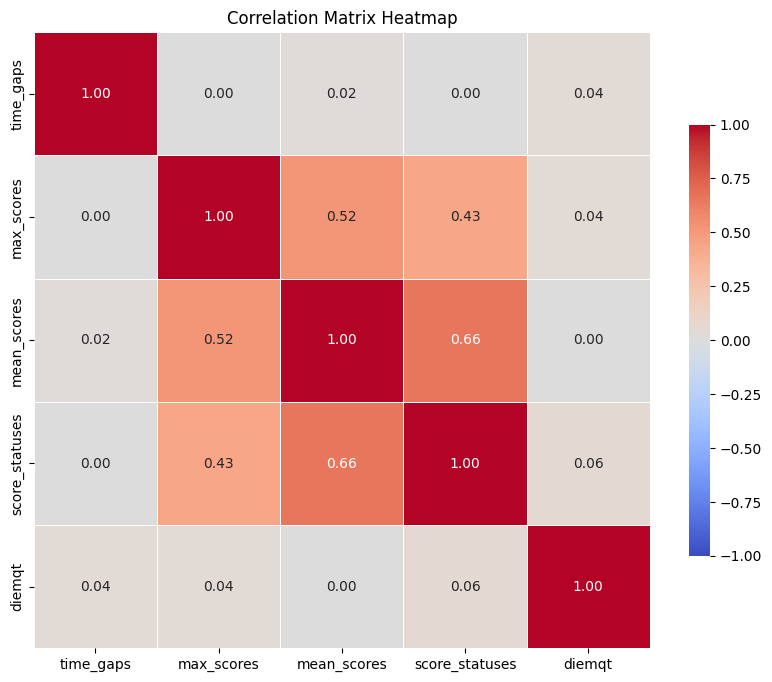

In [173]:
plot_correlation(df_ano_qt_clean)

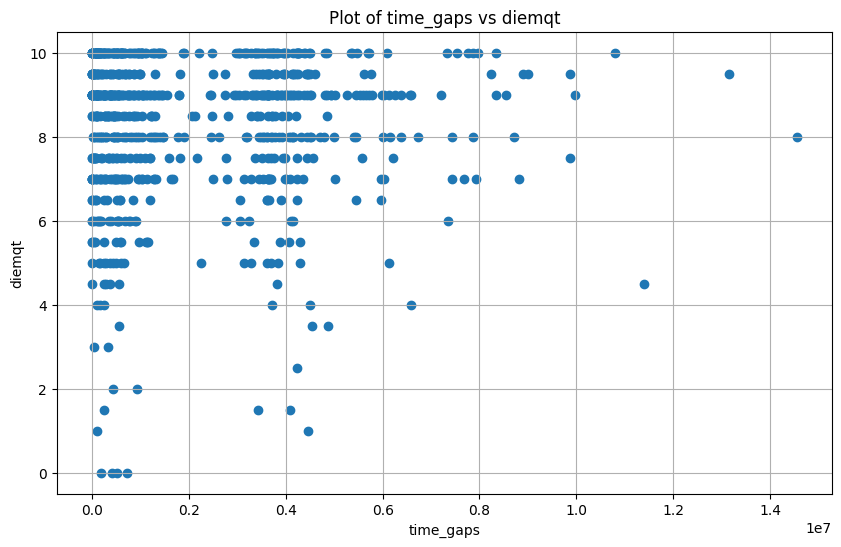

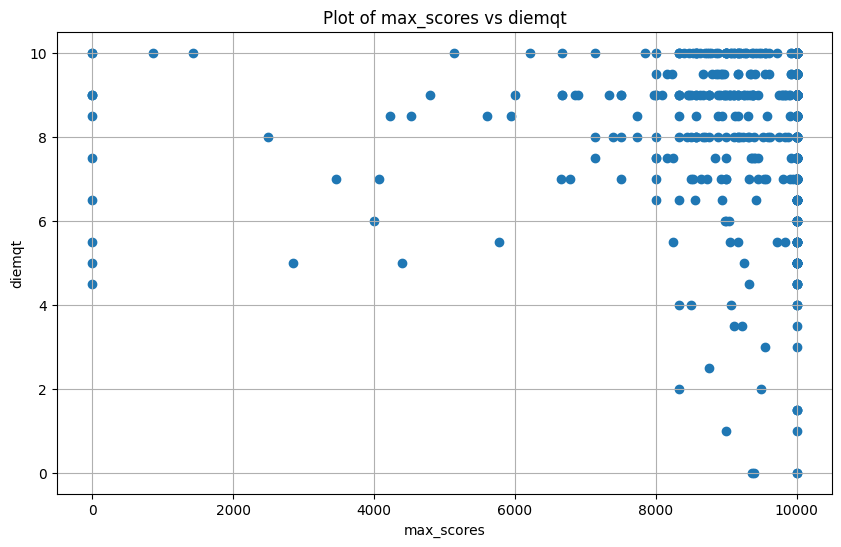

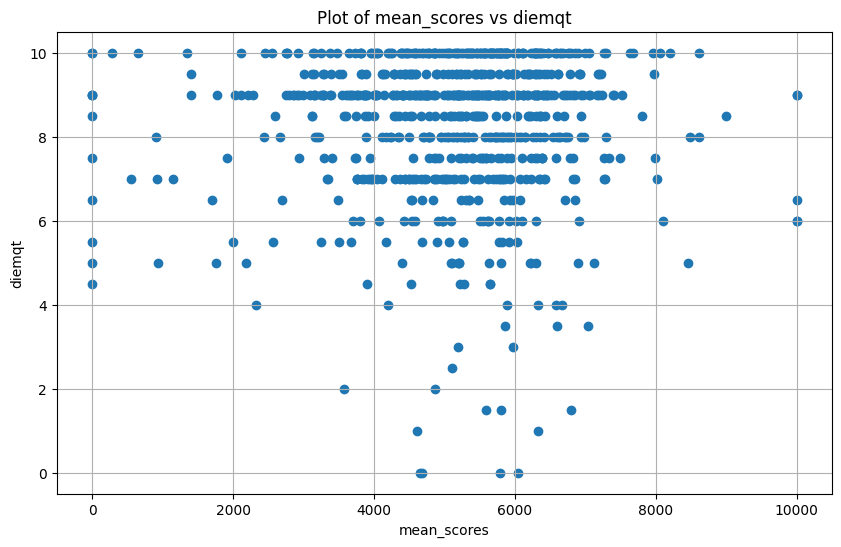

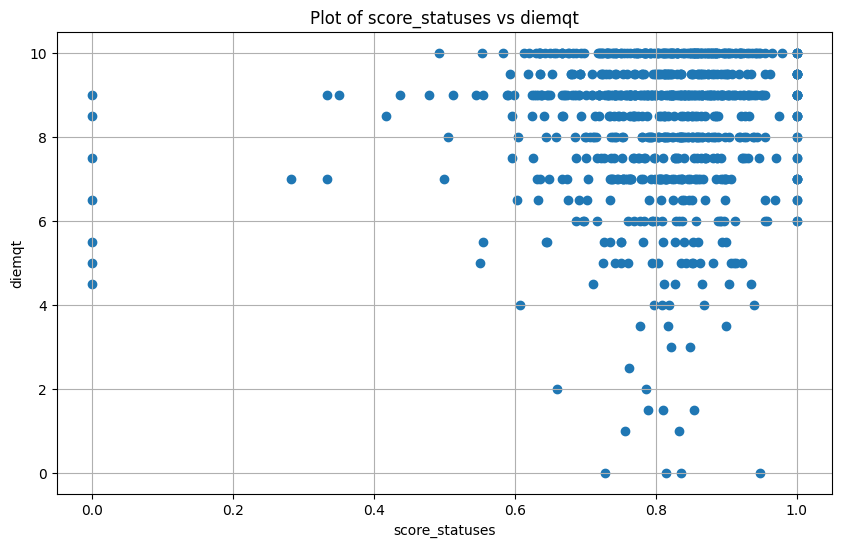

In [174]:
for col_name in df_ano_qt_clean.columns:
    if col_name not in ["username", "diemqt"]:
        plot_feature_vs_target(df_ano_qt_clean, col_name, "diemqt")

In [175]:
train_data_svr(df_ano_qt_clean,
               target_colname= "diemqt",
                model_filename="svr_model_qt.pkl", scaler_X_filename="scaler_X_qt.pkl",scaler_y_filename="scaler_y_qt.pkl")

R^2 score: -0.10453942904708913

Predictions compared to ground truth:
True: 10.00, Predicted: 8.52
True: 10.00, Predicted: 8.56
True: 9.00, Predicted: 9.07
True: 6.50, Predicted: 8.54
True: 7.50, Predicted: 9.30
True: 8.00, Predicted: 9.11
True: 9.00, Predicted: 8.83
True: 2.50, Predicted: 8.95
True: 8.00, Predicted: 8.73
True: 7.50, Predicted: 9.25
True: 10.00, Predicted: 8.85
True: 10.00, Predicted: 8.48
True: 8.50, Predicted: 8.64
True: 6.50, Predicted: 8.50
True: 10.00, Predicted: 8.50
True: 8.50, Predicted: 8.71
True: 7.50, Predicted: 8.81
True: 10.00, Predicted: 8.84
True: 4.00, Predicted: 9.20
True: 9.00, Predicted: 8.55
True: 9.00, Predicted: 8.83
True: 5.00, Predicted: 9.43
True: 10.00, Predicted: 8.81
True: 9.00, Predicted: 9.01
True: 9.00, Predicted: 8.76
True: 9.50, Predicted: 8.87
True: 9.50, Predicted: 8.97
True: 8.50, Predicted: 8.84
True: 7.50, Predicted: 8.63
True: 10.00, Predicted: 8.54
True: 8.00, Predicted: 8.78
True: 8.00, Predicted: 9.14
True: 6.00, Predicted: 8.

In [176]:
df_ano_not_qt = df_ano_original[
    (~df_ano_original["username"].isin(df_qt_score["hash"].values))
]
print(len(df_ano_not_qt))
df_ano_not_qt = extract_student_infos(df_ano_not_qt, None, None)

138158


C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stu_view["created_at_parsed"] = pd.to_datetime(
C:\Users\Admin\AppData\Local\Temp\ipykernel_18908\4244589083.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [177]:
df_ano_not_qt

,username,time_gaps,max_scores,mean_scores,score_statuses
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,5062661.0,10000.0,5305.553957,0.755396
1,ba12c0a2cb367af0467e479c03507c71a805d291,168839.0,10000.0,5228.576803,0.768025
2,b7298b0fe50443a623af9b56792b330c2d052845,214985.0,10000.0,5998.854251,0.854251
3,c60be70309789b39355dc612f36e37090ccad5dc,138553.0,9500.0,6237.773256,0.848837
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,3343121.0,10000.0,5547.465278,0.868056
...,...,...,...,...,...
723,508e0627871ed482bd8ab34544e43e5d856a889c,3305859.0,10000.0,5483.404255,0.797872
724,d525d6edf4b0c6362ddaa4814c3930a6a62bdc99,398989.0,10000.0,6124.041475,0.820276
725,b722e6209f2858faf0bf80947cadcbde586bb666,3957666.0,10000.0,4178.058824,0.830882
726,b45e8d507778dab56f381a681c453cbf4d3b4050,773078.0,8000.0,4841.418440,0.666667


In [179]:
df_ano_predictions = pred_non_labeled_clean(
    df_ano_not_th,
    y_pred=[],
    model_filename="svr_model_th.pkl",
    scaler_X_filename="scaler_X_th.pkl",
    scaler_y_filename="scaler_y_th.pkl",
)
df_ano_predictions.head(10)

,username,predictions
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,7.97
1,ba12c0a2cb367af0467e479c03507c71a805d291,7.64
2,b7298b0fe50443a623af9b56792b330c2d052845,7.59
3,c60be70309789b39355dc612f36e37090ccad5dc,7.46
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,8.19
5,d5841f944022e9ef49bf6ac9b5546dd82ab2784f,9.20
6,eb451c65ea210bed6af798282c2c6205c79f71fd,7.40
7,c3e73d0362e2b21fae6edfcf518063e8a28b7b63,7.64
8,df9e2c6cfb6035fa5b26af3b101bacf64e95e913,7.60
9,99103791231143dd15aa77f2aeb87b2cd4a1c22e,8.33


In [180]:
df_ano_predictions.to_csv('predictions_qt.csv',index=False,header=None)